# Reproducing prior "D"-classifier with current workflow

## Experiment description
### Narrative set-up
Recent results suggest that our current methodology is unable to reproduce the prior results utilizing only degree information (ex33v2.1, see [Reference Figure (1)](#ref-fig-1)). However, this does not rely on embedding information at all and hence, under logistic regression, should be able to reproduce prior "D"-classifier results nearly exactly, up to very minor fluctuations due to random observations. Hence, we find ourselves needing to re-examine the fundamentals of our current workflow's reconstruction.

### Goal
The main goal of this notebook is to examine where the discrepancy in our current results and our previous "D"-classifier results are occurring. This notebook will be limited to exploring configuration models - any actionable insights will be discussed before similar notebooks are created to examine the LFR setting, or (hopefully), we adjust the current code base for more trustworthy results.


---
---

# Set-up

## Package management

In [3]:
# --- Standard library ---
import sys
import pickle
from enum import Enum
import random

# --- Scientific computing ---
import numpy as np
from sklearn.metrics import accuracy_score, roc_auc_score

# --- Network science ---

# --- Data handling and visualization ---
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator
%matplotlib inline

# --- Project source code ---
sys.path.append("../../src/")
from src.data.preprocessing import duplex_network  # handle overlap, inconsistent node sets
from src.data.benchmarks import generate_multiplex_configuration, lfr_multiplex  # benchmark samplers
from src.sampling.random import partial_information  # PFI observation
from src.classifiers.features import get_degrees, get_configuration_probabilities_feature, get_labels  # degree feature calculations, label wrapper
from src.classifiers.logreg import *  # wrappers for scikit-learn logistic regression model functions

## Global config

In [4]:
# * Pathing aliases
_ROOT = "../../"
_DATA = _ROOT + "data/input/"
_DFS = _ROOT + "results/dataframes/"
_FIGS = _ROOT + "results/plots/"

In [5]:
# * Plotting parameters
custom_plot_settings = {
    # Figure config
    "figure.figsize": (8,6),
    "figure.frameon": True,
    "figure.autolayout": True,
    "axes.titlesize": 16,
    # Axes config
    "xtick.minor.size": 2,
    # Save-to-disk config
    "savefig.facecolor": "white",
    "savefig.transparent": False
}
mpl.rcParams.update(custom_plot_settings)

# * Plotting aliases
colors_ = ["black", "red", "blue", "green"]
markers_ = ["o", "s", "+", "^"]
viridis_ = mpl.colormaps['viridis']

---

# Experiment

## Data set-up

### Specify parameters

In [6]:
_DATA_DICT = {
    "N": "number of nodes (in shared node set)",
    "GAMMA": "degree exponent of power-law degree distribution (from sampled distribution, finite sampling effects may yield different exponent if re-fit)",
    "MU": "mixing parameter for LFR model. Smaller MU implies (and is implied by) stronger modular structure.",
    "KMIN": "minimum degree (in either layer)",
    "KMAX": "maximum degree (in either layer)",
    "AVG_K": "average degree (in both layers)",
    "T1": "equivalent to GAMMA for LFR models",
    "T2": "community size power-law distribution exponent",
    "PROB": "relabeling probability. Controls correlation, with 0->1 = correlated->uncorrelated",
    "SIGN": "degree sequence sorting. Couples with PROB to produce anti/directly correlated degree sequences. -1 => anticorrelated, 1 => correlated"
}

In [7]:
class NetworkParams(Enum):
    # Shared params
    N = 100_000
    PROB = 1.0
    GAMMA = 2.1
    KMAX = np.sqrt(100_000)
    # Configuration model params
    KMIN = 3
    SIGN = 1
    # LFR params
    AVG_K = 6.0
    T2 = 1.0
    MU = 0.1
    MIN_COMMUNITY = 1 # ignored

In [8]:
class ExperimentParams(Enum):
    THETAS = np.linspace(0.05, 0.95, 11, endpoint=True)

In [9]:
LOGREG = {"fit_intercept": True, "solver": "newton-cholesky", "penalty": None}

### Sample duplex

In [199]:
duplex = generate_multiplex_configuration(
    int(NetworkParams.N.value),  # number of nodes
    NetworkParams.GAMMA.value,  # degree distribution exponent
    NetworkParams.KMIN.value,  # minimum degree
    NetworkParams.KMAX.value,  # maximum degree
    NetworkParams.PROB.value,  # degree sequence correlation
    NetworkParams.SIGN.value  # (anti)-correlation direction indicator
)

In [200]:
G, H = duplex_network(duplex, 1, 2, verbose=True)

Number of common edges removed: 79
Number of inactive nodes removed from layer 1: 0
Number of inactive nodes removed from layer 2: 0
Size of active node set union from layers 1 and 2: 200000


### Compute remnants

In [201]:
remnants = dict()  # theta -> [remnants infomation] mapping
for theta in ExperimentParams.THETAS.value:
    remnant_G, remnant_H, test_edges, train_edges = partial_information(G, H, theta)
    record = {
        "remnants": (remnant_G, remnant_H),
        "observed_edges": train_edges,
        "unobserved_edges": test_edges
    }
    remnants[theta] = record

## Feature calculation

In [202]:
features = dict()  # theta -> [train features, test features]
labels = dict()  # theta -> [train labels, test labels]

In [203]:
for theta, record in remnants.items():
    # Partially compute degree likelihood feature
    src_degrees_train, tgt_degrees_train = get_degrees(record["remnants"], list(record["observed_edges"].keys()))
    src_degrees_test, tgt_degrees_test = get_degrees(record["remnants"], list(record["unobserved_edges"].keys()))

    # Complete degree likelihood feature calculations
    feature_train = get_configuration_probabilities_feature(src_degrees_train, tgt_degrees_train)
    feature_test = get_configuration_probabilities_feature(src_degrees_test, tgt_degrees_test)

    # Retrieve labels
    labels_train, labels_test = get_labels(record["observed_edges"], record["unobserved_edges"])

    # Save to feature and label mappings
    features[theta] = (feature_train, feature_test)
    labels[theta] = (labels_train, labels_test)

## Model training and evaluation

In [204]:
models = dict()  # theta -> [trained logistic regression]

In [205]:
for theta in ExperimentParams.THETAS.value:
    # Retrieve training labels
    Y = labels[theta][0]

    # Retrieve training features
    X = features[theta][0]

    # Format training features for scikit-learn models
    X = np.array(X).reshape(-1,1)

    # Train model
    model = train_fit_logreg(X, Y, LOGREG)

    # Save to models mapping
    models[theta] = model

In [206]:
model_performances = dict()  # theta -> [performances]

In [207]:
for theta in ExperimentParams.THETAS.value:
    # Retrieve testing labels
    Y = labels[theta][1]

    # Retrieve testing features
    X = features[theta][1]

    # Format testing features for scikit-learn models
    X = np.array(X).reshape(-1,1)

    # Apply model to test data
    model = models[theta]
    accuracy = get_model_accuracy(model, X, Y)
    auroc = get_model_auroc(model, X, Y)
    aupr = get_model_aupr(model, X, Y)
    performances = {
        "accuracy": accuracy,
        "auroc": auroc,
        "aupr": aupr,
    }

    # Save to models mapping
    model_performances[theta] = performances

---

# Analysis

## Retrieving prior results

In [208]:
# Load prior results
with open("../../results/MEC/figure2a_data.pk", "rb") as _fh:
    df_f2a = pickle.load(_fh)

# Reformat synthetic data
gammas = []
pfis = []
aurocs = []
accs = []

for gamma, data_ in df_f2a.items():
    for idx, pfi in enumerate([0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]):
        gammas.append(gamma)
        pfis.append(pfi)
        aurocs.append(data_[-1][idx])
        accs.append(data_[-2][idx])

df_f2 = pd.DataFrame({
    "avg_k": [5]*len(gammas),
    "gamma": gammas,
    "method": ["D"]*len(gammas),
    "pfi": pfis,
    "AUROC": aurocs,
    "Accuracy": accs,
})

## Basic performance analysis and comparison

Text(0.5, 1.0, 'Comparing prior "D"-classifier and current code')

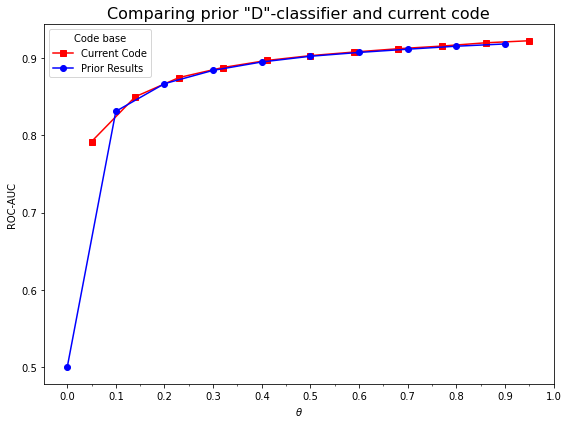

In [209]:
# Instantiate figure, subset relevant data
fig = plt.figure()
X = ExperimentParams.THETAS.value
Y = [perfs["auroc"] for perfs in model_performances.values()]
df_ = df_f2.query("gamma == 2.1")

# Plotting data
plt.plot(
    X, Y,
    label="Current Code",
    color="red",
    marker="s"
)
plt.plot(
    df_["pfi"], df_["AUROC"],
    label="Prior Results",
    color="blue",
    marker="o"
)

# Axes configuration
ax = fig.axes[0]

plt.xticks(np.linspace(0, 1, 11))
ax.xaxis.set_minor_locator(AutoMinorLocator(2))

plt.xlabel("$\\theta$")
plt.ylabel("ROC-AUC")

# Figure-level attributes
plt.legend(title="Code base")
plt.title("Comparing prior \"D\"-classifier and current code")

# Save plot

The performances appear to match now!

The [preliminary results](#ref-fig-1) should match the corresponding case by parameters nearly exactly, except for network size. Perhaps the effect of network size is stronger with our current code base than our previous code base?

# Size Effect


Let's examine our code base by itself controlling network size across a few orders of magnitude.

In [10]:
results = dict()  # N -> experiment results

for N in np.logspace(2, 5, num=4):
    # ~~~~~~~~~~~~~~~~~~~~~~~~~~
    duplex = generate_multiplex_configuration(
        int(N),  # number of nodes
        NetworkParams.GAMMA.value,  # degree distribution exponent
        NetworkParams.KMIN.value,  # minimum degree
        np.sqrt(N),  # maximum degree
        NetworkParams.PROB.value,  # degree sequence correlation
        NetworkParams.SIGN.value  # (anti)-correlation direction indicator
    )
    G, H = duplex_network(duplex, 1, 2, verbose=True)

    # ~~~~~~~~~~~~~~~~~~~~~~~~~~
    remnants = dict()  # theta -> [remnants infomation] mapping
    for theta in ExperimentParams.THETAS.value:
        remnant_G, remnant_H, test_edges, train_edges = partial_information(G, H, theta)
        record = {
            "remnants": (remnant_G, remnant_H),
            "observed_edges": train_edges,
            "unobserved_edges": test_edges
        }
        remnants[theta] = record

    # ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    features = dict()  # theta -> [train features, test features]
    labels = dict()  # theta -> [train labels, test labels]
    for theta, record in remnants.items():
        # Partially compute degree likelihood feature
        src_degrees_train, tgt_degrees_train = get_degrees(record["remnants"], list(record["observed_edges"].keys()))
        src_degrees_test, tgt_degrees_test = get_degrees(record["remnants"], list(record["unobserved_edges"].keys()))

        # Complete degree likelihood feature calculations
        feature_train = get_configuration_probabilities_feature(src_degrees_train, tgt_degrees_train)
        feature_test = get_configuration_probabilities_feature(src_degrees_test, tgt_degrees_test)

        # Retrieve labels
        labels_train, labels_test = get_labels(record["observed_edges"], record["unobserved_edges"])

        # Save to feature and label mappings
        features[theta] = (feature_train, feature_test)
        labels[theta] = (labels_train, labels_test)

    # ~~~~~~~~~~~~~~~~~~~~~~~~
    models = dict()  # theta -> [trained logistic regression]
    for theta in ExperimentParams.THETAS.value:
        # Retrieve training labels
        Y = labels[theta][0]

        # Retrieve training features
        X = features[theta][0]

        # Format training features for scikit-learn models
        X = np.array(X).reshape(-1,1)

        # Train model
        model = train_fit_logreg(X, Y, LOGREG)

        # Save to models mapping
        models[theta] = model

    # ~~~~~~~~~~~~~~~~~~~~~
    model_performances = dict()  # theta -> [performances]
    for theta in ExperimentParams.THETAS.value:
        # Retrieve testing labels
        Y = labels[theta][1]

        # Retrieve testing features
        X = features[theta][1]

        # Format testing features for scikit-learn models
        X = np.array(X).reshape(-1,1)

        # Apply model to test data
        model = models[theta]
        accuracy = get_model_accuracy(model, X, Y)
        auroc = get_model_auroc(model, X, Y)
        aupr = get_model_aupr(model, X, Y)
        performances = {
            "accuracy": accuracy,
            "auroc": auroc,
            "aupr": aupr,
        }

        # Save to models mapping
        model_performances[theta] = performances

    results[N] = model_performances

Number of common edges removed: 4
Number of inactive nodes removed from layer 1: 0
Number of inactive nodes removed from layer 2: 0
Size of active node set union from layers 1 and 2: 200
Number of common edges removed: 27
Number of inactive nodes removed from layer 1: 0
Number of inactive nodes removed from layer 2: 0
Size of active node set union from layers 1 and 2: 2000
Number of common edges removed: 58
Number of inactive nodes removed from layer 1: 0
Number of inactive nodes removed from layer 2: 0
Size of active node set union from layers 1 and 2: 20000
Number of common edges removed: 79
Number of inactive nodes removed from layer 1: 0
Number of inactive nodes removed from layer 2: 0
Size of active node set union from layers 1 and 2: 200000


Text(0.5, 1.0, 'Examining size effect on current code-base')

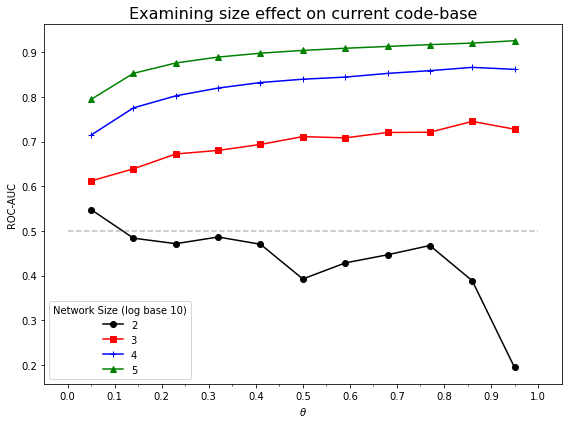

In [11]:
# Instantiate figure, subset relevant data
fig = plt.figure()
X = ExperimentParams.THETAS.value

# Plotting data
for idx, (N, results_) in enumerate(results.items()):
    Y = [perfs["auroc"] for perfs in results_.values()]
    plt.plot(
        X, Y,
        label=int(np.log10(N)),
        color=colors_[idx],
        marker=markers_[idx]
)
plt.hlines(0.5, 0, 1, linestyles="--", color="gray", alpha=0.5)

# Axes configuration
ax = fig.axes[0]

plt.xticks(np.linspace(0, 1, 11))
ax.xaxis.set_minor_locator(AutoMinorLocator(2))

plt.xlabel("$\\theta$")
plt.ylabel("ROC-AUC")

# Figure-level attributes
plt.legend(title="Network Size (log base 10)")
plt.title("Examining size effect on current code-base")

# Save plot

As we can see, there is a pretty strong effect from network size on our current code. I don't recall this being the case for our previous work, so let's recreate the "D"-classifier from the [published source code](https://github.com/kaiser-dan/parametric-dyadic-multiplex-reconstruction/blob/main/experiments/Figure2/figure2.ipynb) now and verify the size effect is weaker in that setting.

In [12]:
def classifier (rem_G1, rem_G2, Etest, TT = 1, show_log = False):
    # >>> D Classifier >>>
    if TT == 1:
        classification, scores, ground_truth = [], [], []

        for e in Etest:
            n = e[0]
            m = e[1]

            s1 = rem_G1.degree(n)*rem_G1.degree(m)
            s2 = rem_G2.degree(n)*rem_G2.degree(m)

            t1 = t2 = 0.5
            if s1 + s2 > 0.0:
                t1 = s1 / (s1 + s2)
                t2 = s2 / (s1 + s2)

            s = random.randint(0,1)
            if t1 > t2:
                s = 1
            if t2 > t1:
                s = 0

            scores.append(t1)
            classification.append(s)
            ground_truth.append(Etest[e])

        return classification, scores, ground_truth
    # <<< D Classifier <<<

In [13]:
def perform_analysis (G1, G2, step, TT = 1):

    # >>> Book-keeping >>>
    x , y, z  = [], [], []
    frac = 0.0
    # <<< Book-keeping <<<

    # >>> Sweep over relative size of training set >>>
    while frac < 1.0:
        if frac <= 1.0 - step:
            print ('# %.2f ' %frac, ' %.2f' %(1.0 - step))

            # Observe information
            rem_G1, rem_G2, Etest, Etrain  = partial_information (G1, G2, frac)

            # Reconstruct multiplex
            classification, scores, ground_truth = classifier (rem_G1, rem_G2, Etest, TT)

            # Measure reconstruction performance
            acc = accuracy_score(ground_truth, classification)
            auc = roc_auc_score(ground_truth, scores)

            x.append(frac)
            y.append(acc)
            z.append(auc)

        frac += step
    # <<< Sweep over relative size of training set <<<

    results = [x, y, z]
    return results

In [14]:
results_D = dict()  # N -> experiment results

for N in np.logspace(2, 5, num=4):
    # ~~~~~~~~~~~~~~~~~~~~~~~~~~
    duplex = generate_multiplex_configuration(
        int(N),  # number of nodes
        NetworkParams.GAMMA.value,  # degree distribution exponent
        NetworkParams.KMIN.value,  # minimum degree
        np.sqrt(N),  # maximum degree
        NetworkParams.PROB.value,  # degree sequence correlation
        NetworkParams.SIGN.value  # (anti)-correlation direction indicator
    )
    G, H = duplex_network(duplex, 1, 2, verbose=True)

    # ~~~~~~~~~~~~~~~~~~~~~~~~~~
    fracs, accs, aucs = perform_analysis(G, H, 0.1)

    results_D[N] = aucs

Number of common edges removed: 17
Number of inactive nodes removed from layer 1: 0
Number of inactive nodes removed from layer 2: 0
Size of active node set union from layers 1 and 2: 200
# 0.00   0.90
# 0.10   0.90
# 0.20   0.90
# 0.30   0.90
# 0.40   0.90
# 0.50   0.90
# 0.60   0.90
# 0.70   0.90
# 0.80   0.90
# 0.90   0.90
Number of common edges removed: 36
Number of inactive nodes removed from layer 1: 0
Number of inactive nodes removed from layer 2: 0
Size of active node set union from layers 1 and 2: 2000
# 0.00   0.90
# 0.10   0.90
# 0.20   0.90
# 0.30   0.90
# 0.40   0.90
# 0.50   0.90
# 0.60   0.90
# 0.70   0.90
# 0.80   0.90
# 0.90   0.90
Number of common edges removed: 52
Number of inactive nodes removed from layer 1: 0
Number of inactive nodes removed from layer 2: 0
Size of active node set union from layers 1 and 2: 20000
# 0.00   0.90
# 0.10   0.90
# 0.20   0.90
# 0.30   0.90
# 0.40   0.90
# 0.50   0.90
# 0.60   0.90
# 0.70   0.90
# 0.80   0.90
# 0.90   0.90
Number of com

Text(0.5, 1.0, 'Examining size effect on "D"-classifier')

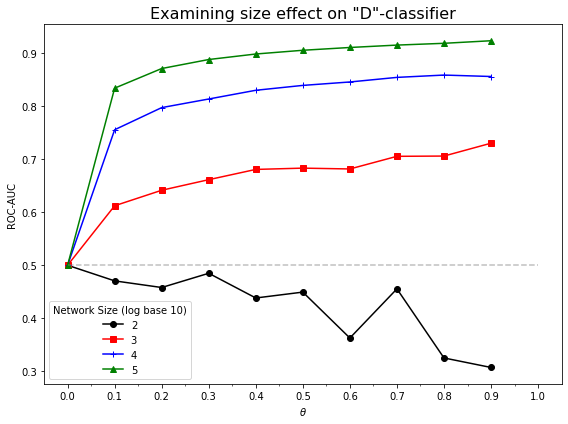

In [15]:
# Instantiate figure, subset relevant data
fig = plt.figure()
X = np.linspace(0,0.9,10)

# Plotting data
for idx, (N, Y) in enumerate(results_D.items()):
    plt.plot(
        X, Y,
        label=int(np.log10(N)),
        color=colors_[idx],
        marker=markers_[idx]
)
plt.hlines(0.5, 0, 1, linestyles="--", color="gray", alpha=0.5)

# Axes configuration
ax = fig.axes[0]

plt.xticks(np.linspace(0, 1, 11))
ax.xaxis.set_minor_locator(AutoMinorLocator(2))

plt.xlabel("$\\theta$")
plt.ylabel("ROC-AUC")

# Figure-level attributes
plt.legend(title="Network Size (log base 10)")
plt.title("Examining size effect on \"D\"-classifier")

# Save plot

Ok so it appears I misremembered - there is indeed a seemingly equally strong effect due to network size with the "D"-classifier as well.

Let's quickly examine the results together

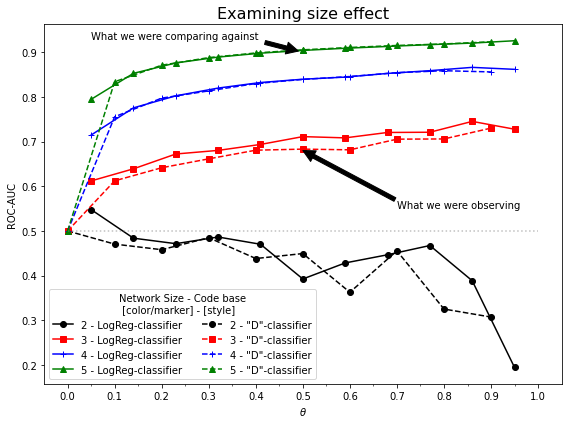

In [20]:
# Instantiate figure, subset relevant data
fig = plt.figure()

# Plotting data
X = ExperimentParams.THETAS.value
for idx, (N, results_) in enumerate(results.items()):
    Y = [perfs["auroc"] for perfs in results_.values()]
    plt.plot(
        X, Y,
        label=f"{int(np.log10(N))} - LogReg-classifier",
        color=colors_[idx],
        marker=markers_[idx]
)
X = np.linspace(0,0.9,10)
for idx, (N, Y) in enumerate(results_D.items()):
    plt.plot(
        X, Y,
        label=f"{int(np.log10(N))} - \"D\"-classifier",
        color=colors_[idx],
        marker=markers_[idx],
        linestyle="--"
)

plt.hlines(0.5, 0, 1, linestyles=":", color="gray", alpha=0.5)

# Axes configuration
ax = fig.axes[0]

plt.xticks(np.linspace(0, 1, 11))
ax.xaxis.set_minor_locator(AutoMinorLocator(2))

plt.xlabel("$\\theta$")
plt.ylabel("ROC-AUC")

# Figure-level attributes
plt.legend(title="Network Size - Code base\n [color/marker] - [style]", ncol=2)
plt.title("Examining size effect")
plt.annotate(
    "What we were comparing against",
    xy=(0.5, 0.9), xytext=(0.05,0.93),
    arrowprops={
        "shrink": 0.1,
        "color": "black"
    }
)
plt.annotate(
    "What we were observing",
    xy=(0.5, 0.68), xytext=(0.7,0.55),
    arrowprops={
        # "shrink": 0.1,
        "color": "black"
    }
)

# Save plot
plt.savefig(f"{_FIGS}/line_auroc-pfi_hue-size_style-method_EMBex34.png")

Fantastic! So if we are careful with our network size, the results may very well match up just fine.

---
---

# Appendix

## Referenced figures

<figure>
    <center>
    <img src="../../results/plots/line_auroc-theta_hue-features_gamma-2.1_compare-DC_EMB_ex33v2.1_DK_20230417.png" alt="ex33v2.1_comparison-fig" class="bg-primary" style="width:50%">
    <figcaption><a id='ref-fig-1'>Reference Figure (1)</a>: EMBex32v2.1 results compared with prior results. </figcaption>
    </center>
</figure>

<!-- ![Extra in case HTML does not render in pandoc export]("../../results/plots/line_auroc-theta_hue-features_gamma-2.1_compare-DC_EMB_ex33v2.1_DK_20230417.png") -->